/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/pyPhysChem



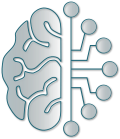

**Start at:** Wednesday 22 November 2023, 18:26:57  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [3]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

# The renaissance of 2nd-order NMR: a model hamiltonian-based rationalization of benchtop NMR spectra

## Introduction to benchtop NMR and simple refresher on NMR

### Benchtop NMR

#### Benchtop NMR *vs.* "usual" high field NMR spectrometer

<div class="intro">
    
<img src="./Misc-Slides/NMR/Slides-BenchtopNMR-01.jpg" alt="NMR1" width="1200" style="display: block; margin: 0 auto; align:center"/> 
</div>

#### Interest of benchtop NMR

<div class="intro">

- Benchtop NMR spectrometers are utilized for various applications in chemistry, biochemistry, food science, materials science, and other fields

- The lower field strength may limit the resolution and sensitivity compared to high-field NMR

- But benchtop NMR devices offer advantages such as portability, ease of use, and accessibility for routine analyses and educational purposes

- Used for tasks like chemical reaction monitoring, quality control in industries, studying molecular structures of small organic molecules, quantifying components in mixtures
</div>

#### Sensitivity of benchtop NMR

<div class="intro">

- Sensitivity can be an issue 

- The sensitivity of an NMR instrument determines its ability to detect and resolve signals from a sample, which directly affects the quality of the acquired spectrum

- Benchtop NMR instruments might struggle to detect low concentrations of certain compounds

- Fortunately, improvements in magnets, electronics, and methodologies continue to enhance benchtop NMR sensitivity

- The quality and homogeneity of the magnetic field is key

<img src="./Misc-Slides/NMR/Figures/SignalAsAFunctionOfB0.png" alt="SignalB0" width="600" style="display: block; margin: 0 auto; align:center"/> 

- A good signal sensitivity allows the detection of low concentration samples, with an adapted acquisition time 

<img src="./Misc-Slides/NMR/Figures/Lidocaine.png" alt="Lidocaine" width="800" style="display: block; margin: 0 auto; align:center"/> 
</div>

### Simple refresher on 1H NMR

#### Proton in a magnetic field, nuclear Zeeman splitting and Larmor frequency, spin-spin coupling

<div class="intro">
    
<img src="./Misc-Slides/NMR/Slides-BenchtopNMR-04.jpg" alt="NMR4" width="1200" style="display: block; margin: 0 auto; align:center"/> 
</div>
<br>
<div class="rqT" title="Start reading the technical paper, sections 1.1 to 1.3">

It's time to start reading the [technical paper](./MiscPDF/NMR-TechnicalPaper-v3.pdf) on the quantum context of the interaction of half-spin nuclei with magnetic fields and the interactions between nuclear spins. **Don't be afraid**. It will be introduced step-by-step in the present notebook. You will discover that such proposed spin hamiltonian description turns out to be crucial in understanding and modeling the so-called **higher-order effects** in NMR spectroscopy, which appear given to the weak magnetic fields of benchtop NMR spectrometers. 

**<u>There is no need to use SymPy to solve the exercises of this part. Use only matplotlib and NumPy</u>**
</div>

<div class="exE" title="Gyromagnetic ratio and other constants">

Import the proton gyromagnetic ratio, Planck constant and reduced Planck constant from `scipy.constant`. Name them `_gamH`, `_h` and `_hbar`. Print their value as well as their unit and their uncertainty.

</div>

In [ ]:
# insert your code below



<div class="exE" title="Absolute resonance frequency">
    
1. define a `nu_0(_B0)` function that will return the absolute resonance frequency for the proton, *ν*<sub>0</sub> (in MHz) as a function of the applied magnetic field, *B*<sub>0</sub> (in Tesla)

2. calculate *ν*<sub>0</sub> for a 1.88 T permanent magnet and a 18.8 T superconducting magnet. Comment on this result in the "comment" markdown cell.

</div>

In [ ]:
# insert your code below



<div class="exE" title="Nuclear Zeeman splitting of a proton in a magnetic field">

    
1. define a `Zeeman_E(_mI,_B0)` function that will return the Zeeman energy (in J) of a nucleus with magnetic quantum number  *m<sub>I</sub>* as a function of the applied magnetic field, *B*<sub>0</sub> (in Tesla). Under an external magnetic field *B*<sub>0</sub>, the energy *E*(*m<sub>I</sub>*, *B*<sub>0</sub>) of a quantum particle with a spin projection *m<sub>I</sub>* on the axis of  *B*<sub>0</sub>  is given by

$$E = -m_I  \hbar \gamma_H B_0$$

(see also equations (10) or (11) of the  [technical paper](./MiscPDF/NMR-TechnicalPaper-v3.pdf))

2. calculate the Zeeman energy splitting, Δ*E* (in J) for protons under an external magnetic field *B*<sub>0</sub> = 1.88 T and 18.8 T

3. calculate for each magnetic field the resonance transition frequency between the levels, in MHz. Comment on this result in the "comment" markdown cell. 

</div>

In [ ]:
# insert your code here



<div class="com">

Insert your comment here
</div>

#### Protons in a chemical environment: chemical shift, chemical shielding, spin-spin coupling

<div class="intro">
    
<img src="./Misc-Slides/NMR/Slides-BenchtopNMR-05.jpg" alt="NMR5" width="1200" style="display: block; margin: 0 auto; align:center"/>  
</div>
<br>
<div class="intro">

And, of course:
- integration in the spectrum provides the relative abundance of protons represented by each peak

- by interpreting these peaks, chemists can deduce the structure, connectivity, and environment of molecules, making proton NMR a powerful tool in chemical analysis and structure determination
 
</div>

<div class="exE" title="Frequency ↔ chemical shift relationships, Larmor frequency">

Later on, it might be useful to have functions that make conversions between resonance frequencies *ν*, in MHz, and chemical shifts *δ*, in ppm. 

$$\delta_i\mathrm{(ppm)} = \frac{\nu_i - \nu_\mathrm{ref}}{\nu_\mathrm{ref}} \times 10^6$$

where $\nu_\mathrm{ref}$ is the frequency of a reference compound, such as TMS.

With $\nu_0$, the operating frequency of the spectrometer employed, defined as the origin of the frequency scale, the previous equation becomes

$$\delta_i\mathrm{(ppm)} = \frac{\nu_i - \nu_0}{\nu_0} \times 10^6$$

1. Analyze what each of the following four functions is supposed to do. Copy/paste the functions in the next Code cell and replace the `enter_your_code` field with the appropriate code.

```python
def delta_i(nu_i, nu_ref):
    '''
    Function that converts a resonance frequency of a proton i into a chemical shift

    Input:
    nu_i = resonance frequency of nucleus i in MHz
    nu_ref = resonance frequency of a reference (eg TMS), in MHz

    Output:
    chemical shift, in ppm
    '''
    return enter_your_code

def nu_i(delta_i, nu0):
    '''
    Function that converts a chemical shift into an absolute resonance frequency

    Input:
        delta_i = chemical shift to convert, in ppm
        nu0 = resonance frequency of the spectrometer, in MHz

    Output:
        absolute resonance frequency nu_i, in MHz
    '''
    return enter_your_code

def nu_i_rel(delta_i, nu0):
    '''
    Function that converts a chemical shift into a relative resonance frequency, i.e. nu_i - nu0

    Input:
        delta_i = chemical shift to convert, in ppm
        nu0 = resonance frequency of the spectrometer, in MHz

    Output:
        relative resonance frequency, in Hz
    '''
    return enter_your_code

def delta_i_rel(nu_i_rel,nu0):
    '''
    Function that converts a relative resonance frequency (nu_i - nu0) into a chemical shift

    Input:
        nu_i_rel = relative resonance frequency, in Hz
        nu0 = resonance frequency of the spectrometer, in MHz

    Output:
        chemical shift, in ppm
    '''
    return enter_your_code
```

<br>

2. Let's remind as well that the Larmor frequency for a proton in chemical environment is:

$$\nu_{\mathrm{L}}(i)=\frac{\gamma_{\mathrm{H}}B_{0}}{2\pi}(1-\sigma_{i})$$

Complete the functions with a `LarmorFreq(B0,sigma)` function that will return the Larmor frequency (in MHz) of a proton in interaction with a *B*<sub>0</sub> external magnetic field (in Tesla), and which has a chemical shielding *σ* (in ppm). Apply the function for *B*<sub>0</sub> = 1.88 T and *σ* = 0 ppm.

3. The resonance of protons of a reference compound, e.g. TMS, are set up as an internal reference of the NMR spectrometer, *i.e.* they are set up to lie at 0 ppm, as the origin of the chemical shift scale. A sample recorded on a 80 MHz spectrometer exhibits a single resonance at 581.60 Hz from the TMS resonance. The signal is observed at 5816.00 Hz from TMS on a 800 MHz spectrometer. Calculate in each case the chemical shift corresponding to the observed resonance. Comment on this result.

4. At which frequency from TMS would be observed the same signal on a 600 MHz spectrometer? What would be its absolute resonance frequency?
</div>

In [ ]:
# enter your code here



<div class="com">

Insert your comment to Q3 and answer to Q4 here
</div>

#### High-order splitting pattern

<div class="intro">

The splitting pattern and the intensity of the peaks was summarized with the Pascal's triangle. The multiplicity of an NMR signal reveals the number of neighboring nuclei that contribute to the splitting, thanks to the 2*nI*+1 rule, where *n* represents the number of adjacent, equivalent protons. Let's consider a compound which resonant nuclei are protons only. With *I* = 1/2, the 2*nI*+1 rule becomes the *n*+1 rule. It means that a proton that appears in the spectrum as a cluster of *m* peaks is surrounded by *m*-1 equivalent protons.

This can rationalize **first-order splitting patterns only**, that are observed when the difference between the frequency resonance (in Hertz) between coupled protons is much larger than the *J* coupling constant. Let's consider two protons a and b, simple first-order will be observed if :

$$\Delta\nu_{ab}\geq10J_{ab}$$

High-order splitting pattern takes place when the difference between the frequency resonance (in Hertz) is much less or the same that order of magnitude as the *J* coupling

$$\Delta\nu_{ab}<10J_{ab}$$

The second order pattern is observed as leaning of a classical pattern: the inner peaks are taller and the outer peaks are shorter. This is called the **roof effect**. For a two-proton system, the difference between first-order and second-order is typically:

<img src="./Misc-Slides/NMR/Figures/JAX_vs_JAB.png" alt="roof_effect" width="400" style="display: block; margin: 0 auto; align:center"/>  

</div>
<br>
<div class="rq">

**Such High-order splitting pattern is likely to be observed on benchtop NMR spectrometers, given the low magnetic field that they operate with.**
</div>

## Introduction to effective hamiltonians that describe coupled "nuclear spins" in an external magnetic field


### Short summary

<div class="rqT" title="Now you have to read sections 1.4 and 1.5">


**In short:**

The total Hamiltonian for any spin system is the summation of individual Hamiltonians, which all describe a particular physical interaction. We will here only consider two prominent interactions, The Zeeman Hamiltonian, $\hat{H}_{\mathrm{Z}}$, which accounts for the magnetic interaction of nuclear spins with the static external field of the spectrometer, and the J-coupling Hamiltonian, $\hat{H}_{\mathrm{J}}$, which accounts for the interaction of pairs of nuclear spins through bonding electrons. The total NMR Hamiltonian is expressed as

$$\hat{H}^{\mathrm{NMR}}=\hat{H}_{\mathrm{Z}}+\hat{H}_{\mathrm{J}}$$

where, in reduced unit of frequency (see section 1.4), the matrix representation of these Hamiltonian operators is

$$\boldsymbol{H}_{\mathrm{Z}}=-\frac{1}{2}\sum_{i=1}^{N}\nu_{i}\boldsymbol{\sigma}_{z_{i}}$$

and

$$\boldsymbol{H}_{\mathrm{J}}=\frac{1}{4}\sum_{i=1}^{N}\sum_{j=1}^{i-1}J_{ij}\left(\boldsymbol{\sigma}_{x_{i}}\boldsymbol{\sigma}_{x_{j}}+\boldsymbol{\sigma}_{y_{i}}\boldsymbol{\sigma}_{y_{j}}+\boldsymbol{\sigma}_{z_{i}}\boldsymbol{\sigma}_{z_{j}}\right)$$

The $\boldsymbol{\sigma}_{q}$ (*q*=*x*, *y* or *z*) are the Pauli matrices: 

$$\boldsymbol{\sigma}_{x}=\left(\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right)\,\,\,\,\,\,\,\,\,\boldsymbol{\sigma}_{y}=\left(\begin{array}{cc}
0 & -i\\
i & 0
\end{array}\right)\,\,\,\,\,\,\,\,\,\boldsymbol{\sigma}_{z}=\left(\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right)$$

It is explained in the [technical paper](./MiscPDF/NMR-TechnicalPaper-v3.pdf) that the practical use of these equations involves the introduction of the so-called Kronecker product (see section 1.5.1 and the introduction of section 1.5.2). Actually, since we will work on matrix representations of operators, we face the necessity to use these Kronecker products:

$\boldsymbol{A}\otimes\boldsymbol{B}$ is the Kronecker product of matrices $\boldsymbol{A}$ and $\boldsymbol{B}$

</div>

### Basic use of the `sympy.physics` functions and modules

<div class="rqT" title = "From now on, you must use SymPy and the symbolic representation of all variables">

All necessary libraries, modules and functions are imported in the next cell. The Pauli matrices $\sigma_x$, $\sigma_y$, $\sigma_z$, $\sigma^+$ and $\sigma^-$ are then saved as `sigma_x`, `sigma_y`, `sigma_z`, `sigma_Plus` and `sigma_Moins`

Do not hesitate to access the [online manual of the `physics` module of SymPy](https://docs.sympy.org/latest/reference/public/physics/index.html).
</div>


In [ ]:
import scipy.constants as sc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

import sympy as sp

from sympy.physics.matrices import msigma # Pauli matrices
# from sympy.physics.paulialgebra import evaluate_pauli_product as epp
from sympy.physics.quantum import TensorProduct # for matrices, this uses matrix_tensor_product to compute the Kronecker or tensor product matrix
from sympy.physics.quantum import represent # represents a quantum expression in the given basis set
from sympy import Identity, eye, Matrix # eye returns and identity matrix, whereas Identity returns the symbolic Matrix Identity I

from IPython.display import Latex
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sp.init_printing(use_unicode=True)

<div class="intro">

Now let's play a bit with some functions and operators

(`sp.I` is the imaginary number)
</div>

In [ ]:
sigma_x = msigma(1)
sigma_y = msigma(2)
sigma_z = msigma(3)
sigma_Plus = (sigma_x + sp.I*sigma_y)/2
sigma_Moins = (sigma_x - sp.I*sigma_y)/2

Latex("$\sigma_x$:")
sigma_x
Latex("$\sigma_y$:")
sigma_y
Latex("$\sigma_z$:")
sigma_z

Latex("$\sigma^+$:")
sigma_Plus
Latex("$\sigma^-$:")
sigma_Moins

<div class="rqE">

**Do not `print` SymPy variables**. `print(SymPy variable)` returns a string form designed to be copied ans pasted.

To display them, just type their name. In a notebook, it will render $\LaTeX$
(if it does not work, use `display` as a backup)

Let's illustrate this in the next cell, to make it clear
</div>

In [ ]:
x= sp.Symbol('x')
example = sp.Integral(3*x**2+1)
t4pPC.centerTitle("print(example) returns a string")
print(example)
t4pPC.centerTitle("type 'example' directly to return a pretty display of the integral")
example
t4pPC.centerTitle("'display(example)' also returns a pretty display of the integral")
display(example)

<div class="intro">

Let's now express the two spin states $\alpha$ and $\beta$ in a two-state basis set
</div>

In [ ]:
alpha = sp.Matrix([1,0])
beta = sp.Matrix([0,1])
alpha
beta

<div class="exE" title="Comment?">

Comment on the results.

What would be the difference with the next possible matrix forms for $\alpha$ and $\beta$?

(answer in the "comment" mardown cell)

$$\alpha=\left(\begin{array}{c}
\frac{1}{2}\\
\frac{1}{2}
\end{array}\right)\,\,\,\,\,\,\,\,\,\,\,\,\beta=\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{2}
\end{array}\right)$$
</div>

<div class="com">

Insert your comment here
</div>

<div class="exE">

Apply the `sigma_Plus` and `sigma_Moins` operators to both `alpha` and `beta`. Comment on the results.
</div>

In [ ]:
# insert your code here



<div class="com">

Insert your comment here
</div>

<div class="intro">

We will see later that some equations depend on the identity matrix. There are two ways to return in identity matrix with SymPy. One is the [`eye` method](https://docs.sympy.org/latest/modules/matrices/common.html#sympy.matrices.common.MatrixCommon.eye), that returns an explicit identity matrix, the second one is the [`Identity` function], that returns a symbolic identity matrix. A symbolic matrix expression can be turned into an explicit matrix with the `as_explicit()` method.

Let's illustrate all this with a 3 &times; 3 identity matrix: 

In [ ]:
t4pPC.centerTitle("eye method")
I_ = eye(3)
I_

t4pPC.centerTitle("Identity method")
I = Identity(3)
I
print(f"Shape of the Identity matrix {I} = {I.shape}")

I_ = I.as_explicit()
I_

<div class="exE" title="Zeeman energies of a single proton in a magnetic field">

Apply the matrix representation of the Zeeman Hamiltonian,$ \boldsymbol{H}_{\mathrm{Z}}$, to the matrix form of the spin states $\alpha$ and $\beta$. Use a symbolic representation of variables. You should find results reported in equations (10) and (11).

**Hint**:

```python
B0 = sp.Symbol("B0", positive=True, real=True)
gamma_H = sp.Symbol("gamma_H", positive=True, real=True)
hbar = sp.Symbol("hbar", positive=True, real=True)
```
</div>

In [ ]:
# insert your code here



### Kronecker products

<div class="intro">

We must use Kronecker products since we will work on matrix representations of operators. For a two-spin system, the Zeeman Hamiltonian is written as

$$\boldsymbol{H}_{\mathrm{Z}}=-\frac{1}{2}\nu_{\mathrm{A}}\boldsymbol{\sigma}_{z_{\mathrm{A}}}\otimes\boldsymbol{\mathrm{1}}-\frac{1}{2}\nu_{\mathrm{B}}\boldsymbol{\mathrm{1}}\otimes\boldsymbol{\sigma}_{z_{\mathrm{B}}}$$

wheras the J-coupling Hamiltonian is formulated as

$$\boldsymbol{H}_{\mathrm{J}}=\frac{1}{4}J_{\mathrm{AB}}(\boldsymbol{\Sigma}_{xx}+\boldsymbol{\Sigma}_{yy}+\boldsymbol{\Sigma}_{zz})$$
</div>

#### Operators for the Zeeman Hamiltonian

<div class="exE" title="Pauli matrix representation in a two-spin system (section 1.5.2)">

1. Define $\boldsymbol{\sigma}_{z_{\mathrm{A}}}\otimes\boldsymbol{\mathrm{1}}$ and $\boldsymbol{\mathrm{1}}\otimes\boldsymbol{\sigma}_{z_{\mathrm{B}}}$ as two new operators `SzA` and `SzB`

2.  Print them out to check that they are correct.
</div>

In [ ]:
# insert your code here



####  Operators for the J-coupling Hamiltonian

<div class="exE" title="Matrix representation of operators of the J-coupling hamiltonian in a two-spin system (section 1.5.2)">

1. Define $\boldsymbol{\Sigma}_{xx}$, $\boldsymbol{\Sigma}_{yy}$ and $\boldsymbol{\Sigma}_{zz}$ as three new operators `Sigma_xx`, `Sigma_yy` and `Sigma_zz`

2.  Display them to check that they are correct.
</div>

In [ ]:
# insert your code here



## Definition and diagonalization of the spin Hamiltonian of an AB system

### Definition of H

#### Zeeman component of the Hamiltonian


<div class="exE" title="Matrix representation of the Zeeman hamiltonian in a two-spin system (section 1.5.2)">

1. Define two symbolic variables `nuA` and `nuB`.

2. Define `Hz`, the symbolic representation of the $\boldsymbol{H}_{\mathrm{Z}}$ Hamiltonian

3. Print it out to check that it is correct (you should find eq. 34)

</div>

In [ ]:
# enter your code here



#### J-coupling Hamiltonian

<div class="exE" title="Matrix representation of the J-coupling hamiltonian in a two-spin system (section 1.5.2)">

1. Define the symbolic variables `JAB`.

2. Define `HJ`, the symbolic representation of the $\boldsymbol{H}_{\mathrm{J}}$ Hamiltonian

3. Print it out to check that it is correct (you should find eq. 35)
</div>

In [ ]:
# enter your code here



#### Total Hamiltonian

<div class="exE">

1. Derive the total hamiltonian, `H`, from the previous results

2. Print it out to check that it is correct (you should find eq. 36)
</div>

In [ ]:
# enter your code here



<div class="rqT" title="Assumption of inequalities">

There is no way in SymPy to assume inequalities, such as that $\nu_\mathrm{A} < \nu_\mathrm{B}$, because the [(old) assumptions system](https://docs.sympy.org/latest/guides/assumptions.html#the-old-assumptions-system) does not support relations.

**What is the practical consequence?** In our case, it will be that SymPy will not be able to simplify to 1 a relationship of the kind:

$$\frac{\nu_{\mathrm{B}}-\nu_{\mathrm{A}}}{|\nu_{\mathrm{A}}-\nu_{\mathrm{B}}|} \quad \quad \quad, \mathrm{with}\; \nu_\mathrm{A} < \nu_\mathrm{B}$$

It's just annoying because some relationships "simplified" by SymPy will apparently be more complicated than they truly are. You will have to do a "visual check" that simplification should apply to some of these results, such as in orthogonality calculations. 
</div>

### Diagonalization of H

<div class="intro">

The eigenvalues of this Hamiltonian can be obtained by diagonalizing the `H` matrix. They correspond to the energies of the spin states of this AB system, whereas the eigenvectors describe these spin states. Actually, do not forget that the NMR Hamiltonian of had been divided by *h*, so that the energies here are directly calculated in Hz
</div>
<br>
<div class="exE">

1. Find the eigenvalues (`E_funit`) and eigenvectors (`V`) of $\boldsymbol{H}^{\mathrm{NMR}}$, where `E_funit` and `V` are (4,) and (4,4) `sympy.matrices.dense.MutableDenseMatrix`, respectively

2. Print the simplified associated frequency and expression of each eigenstate of $\boldsymbol{H}^{\mathrm{NMR}}$

3. Compare your results with eq. (37)-(40). Apart from the fact that they are not in the same order, what else can you see?

**Hints.**
- The [`sp.Matrix()`](https://docs.sympy.org/latest/modules/matrices/dense.html#sympy.matrices.dense.Matrix) utility could be useful
- The [`M.diagonal()`](https://docs.sympy.org/latest/modules/matrices/common.html#sympy.matrices.common.MatrixCommon.diagonal) code returns as a SymPy vector the diagonal elements of the `M` matrix
</div>

In [ ]:
# enter your code here



<div class="com">

Insert your comment here
</div>

### Sorting of the eigenvalues and eigenvectors

<div class="exE">
    
It is necessary to sort the spin states $V_i$ according to their total spin value, $M$. Values for $M$ can easily be calculated because $V_i$ are also eigenvectors of the $I_z$ operators, the eigenvalues will be on the diagonal of the following ***M*** matrix:

$$\boldsymbol{M} = \frac{1}{2}\left[\boldsymbol{V}^{T}(\boldsymbol{I}_{z_{\mathrm{A}}}\otimes\boldsymbol{1}+\boldsymbol{1}\otimes\boldsymbol{I}_{z\mathrm{_{B}}})\boldsymbol{V}\right]$$

1. Calculate ***M***
2. Sort `E_funit` and `V` by increasing values of *M* (see also Fig. 2 of the technical document)
3. Print the sorted `E_funit` matrix and calculate again ***M*** with the sorted `V` matrix
4. Check that the new `V` basis set is orthonormal. Comment on this result.
</div>

In [ ]:
# insert your code here



<div class="com">

Insert your comment here
</div>

### Simulation of an AB spectrum

#### Determination of the intensities and energies of the allowed transitions

<div class="exE">

1. Calculate the transition matrix ***T***, that will be named `TM`
2. From this, deduce the intensity matrix ***I***, that will be named `IM`
3. Finally, deduce the frequency matrix ***ν***, that will be named `FM`

</div>

In [ ]:
# enter your code here



In [ ]:
# enter your code here



In [ ]:
# enter your code here



#### Case studies

<div class="exE">

- Plot a simulated NMR spectrum as vertical lines, in two cases
    - *&nu;*<sub>A</sub> = 195 Hz, *&nu;*<sub>B</sub> = 205 Hz, *J*<sub>AB</sub> = 7 Hz
    - *&nu;*<sub>A</sub> = 150 Hz, *&nu;*<sub>B</sub> = 250 Hz, *J*<sub>AB</sub> = 7 Hz

The first spectrum should look like: 
<img src="./MiscSavedFiguresVideos/NMR-ABcase-C.png" alt="NMRCase1" width="500" style="display: block; margin: 0 auto; align:center"/>

- Comment on these two plots
</div>

##### nuA = 150 Hz, nuB = 250 Hz, JAB = 7 Hz

In [ ]:
# insert your code here



##### nuA = 195 Hz, nuB = 205 Hz, JAB = 7 Hz

In [ ]:
# insert your code here



<div class="com">

Insert your comment here
</div>

##### Simulation of an AB spectrum at 60 MHz

<div class="exE">
The goal of this new exercise is to simulate the AB part of the experimental 1H-NMR spectrum of 3,6-dimethyl-2-nitroaniline, obtained on a 60 Mhz spectrometer:

<figure>
  <img width="500px" src="./MiscImages/1HNMR-3,6-dimethyl-2-nitroaniline.jpg" style="margin-left:auto; margin-right:auto" id="imgNMRaniline_exp"/>
  <figcaption><b>Experimental 1H-NMR spectrum of 3,6-dimethyl-2-nitroaniline, measured on a 60 MHz spectrometer</b><br>(<i>spectrum taken from:</i> H. Günther, NMR Spectroscopy: Basic Principles, Concepts, and Applications in Chemistry, Wiley, 2013)</figcaption>
</figure>
<br>

The *&delta;*<sub>A</sub> and *&delta;*<sub>B</sub> chemical shifts and the *J*<sub>AB</sub> coupling constant can be inferred from the spectrum:
- *&delta;*<sub>A</sub> = 6.3 ppm
- *&delta;*<sub>B</sub> = 6.8 ppm
- *J*<sub>AB</sub> = 10 Hz

1. Calculate the absolute resonance frequencies of protons H<sup>*a*</sup> and H<sup>*b*</sup>, as well as their frequencies relative to TMS
2. Use these parameters with the developed AB NMR Hamiltonian to calculate and plot the simulated AB part of the 1H NMR spectrum of 3,6-dimethyl-2-nitroaniline. How does it compare with its experimental counterpart ?

**Optional question.** Plot the simulated NMR spectrum with two axis that share the same x-axis: one related to chemical shifts, the second one to the corresponding relative resonance frequencies. And sum the signals with Lorentzian functions. It should look like:

<figure>
  <img width="500px" src="./MiscSavedFiguresVideos/3_6-dimethyl-2-nitroaniline-NMRSpectrum-C.png" style="margin-left:auto; margin-right:auto" id="imgNMRaniline_simul"/>
  <figcaption><b>Simulated 60 MHz 1H-NMR spectrum of 3,6-dimethyl-2-nitroaniline</b></figcaption>
</figure>
 
</div>

In [ ]:
# insert your code here



<div class="com">

Insert your comment here
</div>

<div class="exE">

The same case has been simulated between *&nu;*<sub>0</sub> = 60 MHz and *&nu;*<sub>0</sub> = 800 MHz

Run the cell below to load an animated plot. Comment on what you observe.
</div>

In [ ]:
from IPython import display 
with open("./MiscSavedFiguresVideos/AB2AXsaved.html", "r") as f:
    video = f.read()
html = display.HTML(video) 
display.display(html) 

<div class="com">

Insert your comment here
</div>

In [4]:
vID.end(cwd0)

**End at:** Wednesday 22 November 2023, 18:27:04  
**Duration:** 00:00:07 397ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>